In [1]:
## This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/System-Threat-Forecaster/sample_submission.csv
/kaggle/input/System-Threat-Forecaster/train.csv
/kaggle/input/System-Threat-Forecaster/test.csv


# **Libraries**

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from IPython.display import display, HTML
from tabulate import tabulate
from rich.console import Console
from rich.table import Table
from sklearn.linear_model import Lasso,LogisticRegression,Ridge,SGDClassifier
from sklearn.metrics import mean_squared_error,accuracy_score, confusion_matrix, classification_report
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier 
from xgboost import XGBClassifier
import warnings
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# **MileStone-1**

# **Data Loading**

In [3]:
df_train = pd.read_csv('/kaggle/input/System-Threat-Forecaster/train.csv')
df_test = pd.read_csv('/kaggle/input/System-Threat-Forecaster/test.csv')
sample = pd.read_csv('/kaggle/input/System-Threat-Forecaster/sample_submission.csv')

# **Dummy Classifier**

In [4]:
X=df_train.drop("target", axis=1)
y=df_train["target"]

from sklearn.dummy import DummyClassifier
model = DummyClassifier().fit(X,y)

y_pred = model.predict(df_test)

submission = pd.DataFrame({
    "id": range(0,df_test.shape[0]),
    "target":y_pred
})
submission.to_csv("submissiondummy.csv", index=False)

# **Exploratory Data Analysis**

# Train Data

Info and Shape 

In [5]:
print("train-shape:")
print(df_train.shape)
print()

# ....................................

print("train-info:")
print(df_train.info())
print()

train-shape:
(100000, 76)

train-info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 76 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   MachineID                           100000 non-null  object 
 1   ProductName                         100000 non-null  object 
 2   EngineVersion                       100000 non-null  object 
 3   AppVersion                          100000 non-null  object 
 4   SignatureVersion                    100000 non-null  object 
 5   IsBetaUser                          100000 non-null  int64  
 6   RealTimeProtectionState             99934 non-null   float64
 7   IsPassiveModeEnabled                100000 non-null  int64  
 8   AntivirusConfigID                   99924 non-null   float64
 9   NumAntivirusProductsInstalled       99924 non-null   float64
 10  NumAntivirusProductsEnabled         99924 non-null   f

# **Train Data (Head)**

In [6]:
pd.set_option("display.max_columns", None)  
pd.set_option("display.width", 1000)        
pd.set_option("display.float_format", "{:.2f}".format)
pd.set_option("display.max_colwidth", 1000)

def style_dataframe(df):
    return df.style \
        .set_properties(**{'background-color': '#f9f9f9', 'color': 'black', 'border': '1px solid lightgrey'}) \
        .set_table_styles([{
            'selector': 'thead th',
            'props': [('font-weight', 'bold'), ('background-color', '#e0e0e0'), ('color', 'black'), ('text-align', 'center')]
        }, {
            'selector': 'tbody td',
            'props': [('padding', '8px'), ('text-align', 'center')]
        }])


styled_train_head = style_dataframe(df_train.head())
styled_train_head

,MachineID,ProductName,EngineVersion,AppVersion,SignatureVersion,IsBetaUser,RealTimeProtectionState,IsPassiveModeEnabled,AntivirusConfigID,NumAntivirusProductsInstalled,NumAntivirusProductsEnabled,HasTpm,CountryID,CityID,GeoRegionID,LocaleEnglishNameID,PlatformType,Processor,OSVersion,OSBuildNumber,OSProductSuite,OsPlatformSubRelease,OSBuildLab,SKUEditionName,IsSystemProtected,AutoSampleSubmissionEnabled,SMode,IEVersionID,FirewallEnabled,EnableLUA,MDC2FormFactor,DeviceFamily,OEMNameID,OEMModelID,ProcessorCoreCount,ProcessorManufacturerID,ProcessorModelID,PrimaryDiskCapacityMB,PrimaryDiskType,SystemVolumeCapacityMB,HasOpticalDiskDrive,TotalPhysicalRAMMB,ChassisType,PrimaryDisplayDiagonalInches,PrimaryDisplayResolutionHorizontal,PrimaryDisplayResolutionVertical,PowerPlatformRole,InternalBatteryNumberOfCharges,NumericOSVersion,OSArchitecture,OSBranch,OSBuildNumberOnly,OSBuildRevisionOnly,OSEdition,OSSkuFriendlyName,OSInstallType,OSInstallLanguageID,OSUILocaleID,AutoUpdateOptionsName,IsPortableOS,OSGenuineState,LicenseActivationChannel,IsFlightsDisabled,FlightRing,FirmwareManufacturerID,FirmwareVersionID,IsSecureBootEnabled,IsVirtualDevice,IsTouchEnabled,IsPenCapable,IsAlwaysOnAlwaysConnectedCapable,IsGamer,RegionIdentifier,DateAS,DateOS,target
0,f541bae429089117c4aac39c90dd3416,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1003.0,0,7.000000,0,53447.000000,1.000000,1.000000,1,51,120232.000000,98.000000,103,windows10,x86,10.0.0.0,14393,768,rs1,14393.2214.x86fre.rs1_release_1.180402-1758,Home,1.000000,0,0.000000,98.000000,1.000000,1.000000,SmallTablet,Windows.Desktop,561.000000,330367.000000,4.000000,5.000000,1850.000000,15028.000000,SSD,14348.000000,0,1024.000000,Notebook,8.000000,800.000000,1280.000000,Slate,142.000000,10.0.14393.2214,x86,rs1_release,14393,2214,Core,CORE,Update,5.000000,26,UNKNOWN,0,IS_GENUINE,Retail,0.000000,Retail,513.000000,21964.000000,0,0.000000,1,0,1.000000,0.000000,6.000000,2018-09-10 10:11:00,2018-04-17,0
1,dc2b14d9ce3a0ce4050bb640190f2ca5,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1465.0,0,7.000000,0,53447.000000,1.000000,1.000000,1,141,112854.000000,167.000000,227,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.000000,0,0.000000,137.000000,1.000000,1.000000,AllInOne,Windows.Desktop,2668.000000,25212.000000,4.000000,5.000000,2407.000000,953869.000000,HDD,952592.000000,1,4096.000000,AllinOne,19.400000,1600.000000,900.000000,Desktop,4294967295.000000,10.0.17134.228,amd64,rs4_release,17134,228,Professional,PROFESSIONAL,UUPUpgrade,9.000000,34,FullAuto,0,IS_GENUINE,OEM:DM,0.000000,Retail,628.000000,44548.000000,1,0.000000,0,0,0.000000,0.000000,10.000000,2018-08-16 00:01:00,2018-08-14,1
2,fd20c5f010e9c5f91ad1c6b3e0da68a0,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1546.0,0,7.000000,0,53447.000000,1.000000,1.000000,1,51,41759.000000,98.000000,103,windows10,x64,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1.000000,0,0.000000,137.000000,1.000000,1.000000,Desktop,Windows.Desktop,3035.000000,263666.000000,4.000000,5.000000,2719.000000,228936.000000,SSD,228321.000000,1,8192.000000,Desktop,24.000000,1920.000000,1080.000000,Desktop,4294967295.000000,10.0.17134.285,amd64,rs4_release,17134,285,Core,CORE,Reset,5.000000,26,FullAuto,0,IS_GENUINE,OEM:NONSLP,0.000000,Retail,142.000000,9414.000000,0,0.000000,0,0,0.000000,1.000000,6.000000,2018-09-20 23:20:00,2018-09-11,1
3,38711eae85eb77a72ec5dfdf27eb2a76,win8defender,1.1.15200.1,4.12.17007.18011,1.275.1141.0,0,7.000000,0,46413.000000,2.000000,1.000000,1,68,19507.000000,276.000000,74,windows10,x64,10.0.0.0,15063,768,rs2,15063.0.amd64fre.rs2_release.170317-1834,Home,1.000000,0,0.000000,108.000000,1.000000,1.000000,Notebook,Windows.Desktop,2102.000000,242491.000000,4.000000,5.000000,3410.000000,1907729.000000,HDD,1890776.000000,0,8192.000000,Notebook,15.500000,1366.000000,768.000000,Mobile,0.000000,10.0.15063.850,amd64,rs2_release,15063,850,Core,CORE,Upgrade,7.000000,30,UNKNOWN,0,IS_GENUINE,OEM:DM,0.000000,Retai

# Test Data

**Test data shape and info**

In [7]:
print("test-shape:")
print(df_test.shape)
print()


# .....................................................

print("test-info:")
print(df_test.info())
print()


test-shape:
(10000, 75)

test-info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 75 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   MachineID                           10000 non-null  object 
 1   ProductName                         10000 non-null  object 
 2   EngineVersion                       10000 non-null  object 
 3   AppVersion                          10000 non-null  object 
 4   SignatureVersion                    10000 non-null  object 
 5   IsBetaUser                          10000 non-null  int64  
 6   RealTimeProtectionState             9991 non-null   float64
 7   IsPassiveModeEnabled                10000 non-null  int64  
 8   AntivirusConfigID                   9998 non-null   float64
 9   NumAntivirusProductsInstalled       9998 non-null   float64
 10  NumAntivirusProductsEnabled         9998 non-null   float64
 11  HasTpm

# **Test Data Head**

In [8]:
styled_test_head = style_dataframe(df_test.head())
styled_test_head

,MachineID,ProductName,EngineVersion,AppVersion,SignatureVersion,IsBetaUser,RealTimeProtectionState,IsPassiveModeEnabled,AntivirusConfigID,NumAntivirusProductsInstalled,NumAntivirusProductsEnabled,HasTpm,CountryID,CityID,GeoRegionID,LocaleEnglishNameID,PlatformType,Processor,OSVersion,OSBuildNumber,OSProductSuite,OsPlatformSubRelease,OSBuildLab,SKUEditionName,IsSystemProtected,AutoSampleSubmissionEnabled,SMode,IEVersionID,FirewallEnabled,EnableLUA,MDC2FormFactor,DeviceFamily,OEMNameID,OEMModelID,ProcessorCoreCount,ProcessorManufacturerID,ProcessorModelID,PrimaryDiskCapacityMB,PrimaryDiskType,SystemVolumeCapacityMB,HasOpticalDiskDrive,TotalPhysicalRAMMB,ChassisType,PrimaryDisplayDiagonalInches,PrimaryDisplayResolutionHorizontal,PrimaryDisplayResolutionVertical,PowerPlatformRole,InternalBatteryNumberOfCharges,NumericOSVersion,OSArchitecture,OSBranch,OSBuildNumberOnly,OSBuildRevisionOnly,OSEdition,OSSkuFriendlyName,OSInstallType,OSInstallLanguageID,OSUILocaleID,AutoUpdateOptionsName,IsPortableOS,OSGenuineState,LicenseActivationChannel,IsFlightsDisabled,FlightRing,FirmwareManufacturerID,FirmwareVersionID,IsSecureBootEnabled,IsVirtualDevice,IsTouchEnabled,IsPenCapable,IsAlwaysOnAlwaysConnectedCapable,IsGamer,RegionIdentifier,DateAS,DateOS
0,c2c61173092ad20db5585ca8c10de6e0,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1276.0,0,7.000000,0,53447.000000,1.000000,1.000000,1,218,129455.000000,224.000000,16,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.000000,0,0.000000,137.000000,1.000000,1.000000,Notebook,Windows.Desktop,2102.000000,249148.000000,4.000000,5.000000,3026.000000,953869.000000,HDD,134182.000000,0,8192.000000,Notebook,15.500000,1366.000000,768.000000,Mobile,0.000000,10.0.17134.165,amd64,rs4_release,17134,165,Professional,PROFESSIONAL,UUPUpgrade,1.000000,5,FullAuto,0,INVALID_LICENSE,Retail,0.000000,Retail,486.000000,48751.000000,0,0.000000,0,0,0.000000,1.000000,11.000000,2018-08-12 13:12:00,2018-07-10
1,2e6bb5362ba1ce897feeb1de5edea686,win8defender,1.1.15100.1,4.10.209.0,1.273.371.0,0,7.000000,0,46184.000000,2.000000,2.000000,1,68,138510.000000,276.000000,74,windows8,x64,6.3.0.0,9600,768,windows8.1,9600.19067.amd64fre.winblue_ltsb_escrow.180619-2033,Home,1.000000,0,0.000000,333.000000,1.000000,1.000000,Notebook,Windows.Desktop,585.000000,189972.000000,2.000000,5.000000,3403.000000,715404.000000,HDD,695042.000000,0,8192.000000,Notebook,15.500000,1366.000000,768.000000,Mobile,0.000000,10.0.14393.321,amd64,rs1_release,14393,321,Core,CORE,Update,7.000000,30,FullAuto,0,IS_GENUINE,Retail,0.000000,Retail,556.000000,64709.000000,1,0.000000,0,0,0.000000,0.000000,12.000000,2018-07-26 06:54:00,2016-10-11
2,692649baed1c50bb8d051ae7f06e3625,win8defender,1.1.15200.1,4.18.1807.18075,1.275.263.0,0,7.000000,0,51954.000000,2.000000,1.000000,1,141,154469.000000,167.000000,227,windows10,x64,10.0.0.0,16299,768,rs3,16299.431.amd64fre.rs3_release_svc_escrow.180502-1908,Home,1.000000,0,0.000000,117.000000,1.000000,1.000000,Notebook,Windows.Desktop,2102.000000,242491.000000,4.000000,5.000000,3410.000000,953869.000000,HDD,931858.000000,0,4096.000000,Notebook,15.500000,1366.000000,768.000000,Mobile,0.000000,10.0.16299.431,amd64,rs3_release_svc_escrow,16299,431,CoreSingleLanguage,CORE_SINGLELANGUAGE,Upgrade,10.000000,35,Notify,0,IS_GENUINE,OEM:DM,0.000000,Retail,554.000000,33094.000000,1,0.000000,0,0,0.000000,0.000000,10.000000,2018-08-27 17:29:00,2018-05-08
3,2ff95e7d97e9f80ec81c97622dd93ed6,win8defender,1.1.15300.6,4.18.1807.18075,1.277.58.0,0,7.000000,0,41571.000000,2.000000,1.000000,1,41,130775.000000,240.000000,217,windows10,x64,10.0.0.0,16299,768,rs3,16299.431.amd64fre.rs3_release_svc_escrow.180502-1908,Home,1.000000,0,0.000000,117.000000,1.000000,1.000000,Notebook,Windows.Desktop,2668.000000,171094.000000,4.000000,1.000000,77.000000,953869.000000,HDD,455936.000000,0,16384.000000,Notebook,13.900000,1920.000000,1080.000000,Mobile,0.000000,10.0.16299.431,amd64,rs3_release_svc_escrow,16299,431,CoreSingleLanguag

# **Dataset Statistics and Metadata Overview**

In [9]:
pd.set_option("display.max_columns", None)  
pd.set_option("display.width", 1000)        
pd.set_option("display.float_format", "{:.4e}".format)
pd.set_option("display.max_colwidth", 1000)


describe_df = df_train.describe().transpose()

def style_dataframe(df):
    return df.style \
        .set_properties(**{'background-color': '#f9f9f9', 'color': 'black', 'border': '1px solid lightgrey'}) \
        .set_table_styles([{
            'selector': 'thead th',
            'props': [('font-weight', 'bold'), ('background-color', '#e0e0e0'), ('color', 'black'), ('text-align', 'center')]
        }, {
            'selector': 'tbody td',
            'props': [('padding', '8px'), ('text-align', 'center')]
        }]) \
        .highlight_max(axis=0, color='lightgreen') \
        .highlight_min(axis=0, color='salmon')



styled_describe_df = style_dataframe(describe_df)
print("Comprehensive Statistical Summary and Dataset Information")
print("----------------------------------------------------------")
styled_describe_df

Comprehensive Statistical Summary and Dataset Information
----------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
IsBetaUser,100000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
RealTimeProtectionState,99934.000000,6.848430,1.015166,0.000000,7.000000,7.000000,7.000000,8.000000
IsPassiveModeEnabled,100000.000000,0.017620,0.131566,0.000000,0.000000,0.000000,0.000000,1.000000
AntivirusConfigID,99924.000000,47975.710440,13803.321533,39.000000,49480.000000,53447.000000,53447.000000,70490.000000
NumAntivirusProductsInstalled,99924.000000,1.326528,0.520681,1.000000,1.000000,1.000000,2.000000,5.000000
NumAntivirusProductsEnabled,99924.000000,1.018264,0.155291,0.000000,1.000000,1.000000,1.000000,4.000000
HasTpm,100000.000000,0.996780,0.056654,0.000000,1.000000,1.000000,1.000000,1.000000
CountryID,100000.000000,108.078790,63.062151,1.000000,51.000000,97.000000,162.000000,222.000000
CityID,99377.000000,81029.938587,48944.027074,7.000000,36694.000000,82373.000000,122835.000000,167957.000000
GeoRegionID,100000.000000,169.741630,89.188929,1.000000,89.000000,181.000000,267.000000,296.000000


**Light Green**: The maximum values (highest values) in each column are highlighted in light green to indicate the "best" or highest measurement for that column.
**Salmon (Light Red):** The minimum values (lowest values) in each column are highlighted in salmon to represent the "worst" or lowest measurement for that column

In [10]:
pd.set_option("display.max_columns", None)  
pd.set_option("display.width", 1000)        
pd.set_option("display.float_format", "{:.4e}".format)
pd.set_option("display.max_colwidth", 1000)


def style_dataframe(df):
    return df.style \
        .set_properties(**{'background-color': '#f9f9f9', 'color': 'black', 'border': '1px solid lightgrey'}) \
        .set_table_styles([{
            'selector': 'thead th',
            'props': [('font-weight', 'bold'), ('background-color', '#e0e0e0'), ('color', 'black'), ('text-align', 'center')]
        }, {
            'selector': 'tbody td',
            'props': [('padding', '8px'), ('text-align', 'center')]
        }])


key_insights = {
    "Insight": [
        "Total Features and Target Variable",
        "Diverse Data Types",
        "Data Size",
        "IsBetaUser (Constant Feature)",
        "RealTimeProtectionState (Concentrated Distribution)",
        "IsPassiveModeEnabled (Low Variability)",
        "AntivirusConfigID (Wide Range)",
        "NumAntivirusProductsInstalled (Mostly 1)",
        "NumAntivirusProductsEnabled (Mostly 1)",
        "HasTpm (Almost All Systems)",
        "CountryID and GeoRegionID (Diverse Geographies)",
        "OSBuildNumber (Different OS Versions)",
        "Target Variable (Balanced)"
    ],
    "Details": [
        "The dataset contains 75 features and 1 target variable. There is a mix of different data types.",
        "The data includes a mix of integer, floating-point, and categorical data types.",
        "The dataset contains 100,000 rows (entries) for analysis.",
        "IsBetaUser has a constant value of 0 across all entries and does not provide variability.",
        "RealTimeProtectionState has a mean value of 6.85 and a concentration at 7, indicating most systems have this protection state.",
        "The IsPassiveModeEnabled feature has a very low variability, with most systems having a value of 0.",
        "AntivirusConfigID shows a wide range, indicating diverse antivirus configurations across systems.",
        "The NumAntivirusProductsInstalled feature shows that most systems have a single antivirus product installed.",
        "NumAntivirusProductsEnabled is similarly concentrated, with most systems having one antivirus product enabled.",
        "The HasTpm feature shows that nearly all systems (99.67%) have a TPM, which is significant for security features.",
        "CountryID and GeoRegionID show a range of values, suggesting the dataset spans multiple countries and regions.",
        "OSBuildNumber reveals a variety of OS versions used across the systems in the dataset, from older to more recent builds.",
        "The target variable is balanced with a mean of 0.5052, making it suitable for a binary classification task."
    ]
}


key_insights_df = pd.DataFrame(key_insights)
styled_key_insights_df = style_dataframe(key_insights_df)
styled_key_insights_df

,Insight,Details
0,Total Features and Target Variable,The dataset contains 75 features and 1 target variable. There is a mix of different data types.
1,Diverse Data Types,"The data includes a mix of integer, floating-point, and categorical data types."
2,Data Size,"The dataset contains 100,000 rows (entries) for analysis."
3,IsBetaUser (Constant Feature),IsBetaUser has a constant value of 0 across all entries and does not provide variability.
4,RealTimeProtectionState (Concentrated Distribution),"RealTimeProtectionState has a mean value of 6.85 and a concentration at 7, indicating most systems have this protection state."
5,IsPassiveModeEnabled (Low Variability),"The IsPassiveModeEnabled feature has a very low variability, with most systems having a value of 0."
6,AntivirusConfigID (Wide Range),"AntivirusConfigID shows a wide range, indicating diverse antivirus configurations across systems."
7,NumAntivirusProductsInstalled (Mostly 1),The NumAntivirusProductsInstalled feature shows that most systems have a single antivirus product installed.
8,NumAntivirusProductsEnabled (Mostly 1),"NumAntivirusProductsEnabled is similarly concentrated, with most systems having one antivirus product enabled."
9,HasTpm (Almost All Systems),"The HasTpm feature shows that nearly all systems (99.67%) have a TPM, which is significant for security features."


# Data visualization

array([[<Axes: title={'center': 'IsBetaUser'}>,
        <Axes: title={'center': 'RealTimeProtectionState'}>,
        <Axes: title={'center': 'IsPassiveModeEnabled'}>,
        <Axes: title={'center': 'AntivirusConfigID'}>,
        <Axes: title={'center': 'NumAntivirusProductsInstalled'}>,
        <Axes: title={'center': 'NumAntivirusProductsEnabled'}>,
        <Axes: title={'center': 'HasTpm'}>],
       [<Axes: title={'center': 'CountryID'}>,
        <Axes: title={'center': 'CityID'}>,
        <Axes: title={'center': 'GeoRegionID'}>,
        <Axes: title={'center': 'LocaleEnglishNameID'}>,
        <Axes: title={'center': 'OSBuildNumber'}>,
        <Axes: title={'center': 'OSProductSuite'}>,
        <Axes: title={'center': 'IsSystemProtected'}>],
       [<Axes: title={'center': 'AutoSampleSubmissionEnabled'}>,
        <Axes: title={'center': 'SMode'}>,
        <Axes: title={'center': 'IEVersionID'}>,
        <Axes: title={'center': 'FirewallEnabled'}>,
        <Axes: title={'center': 'En

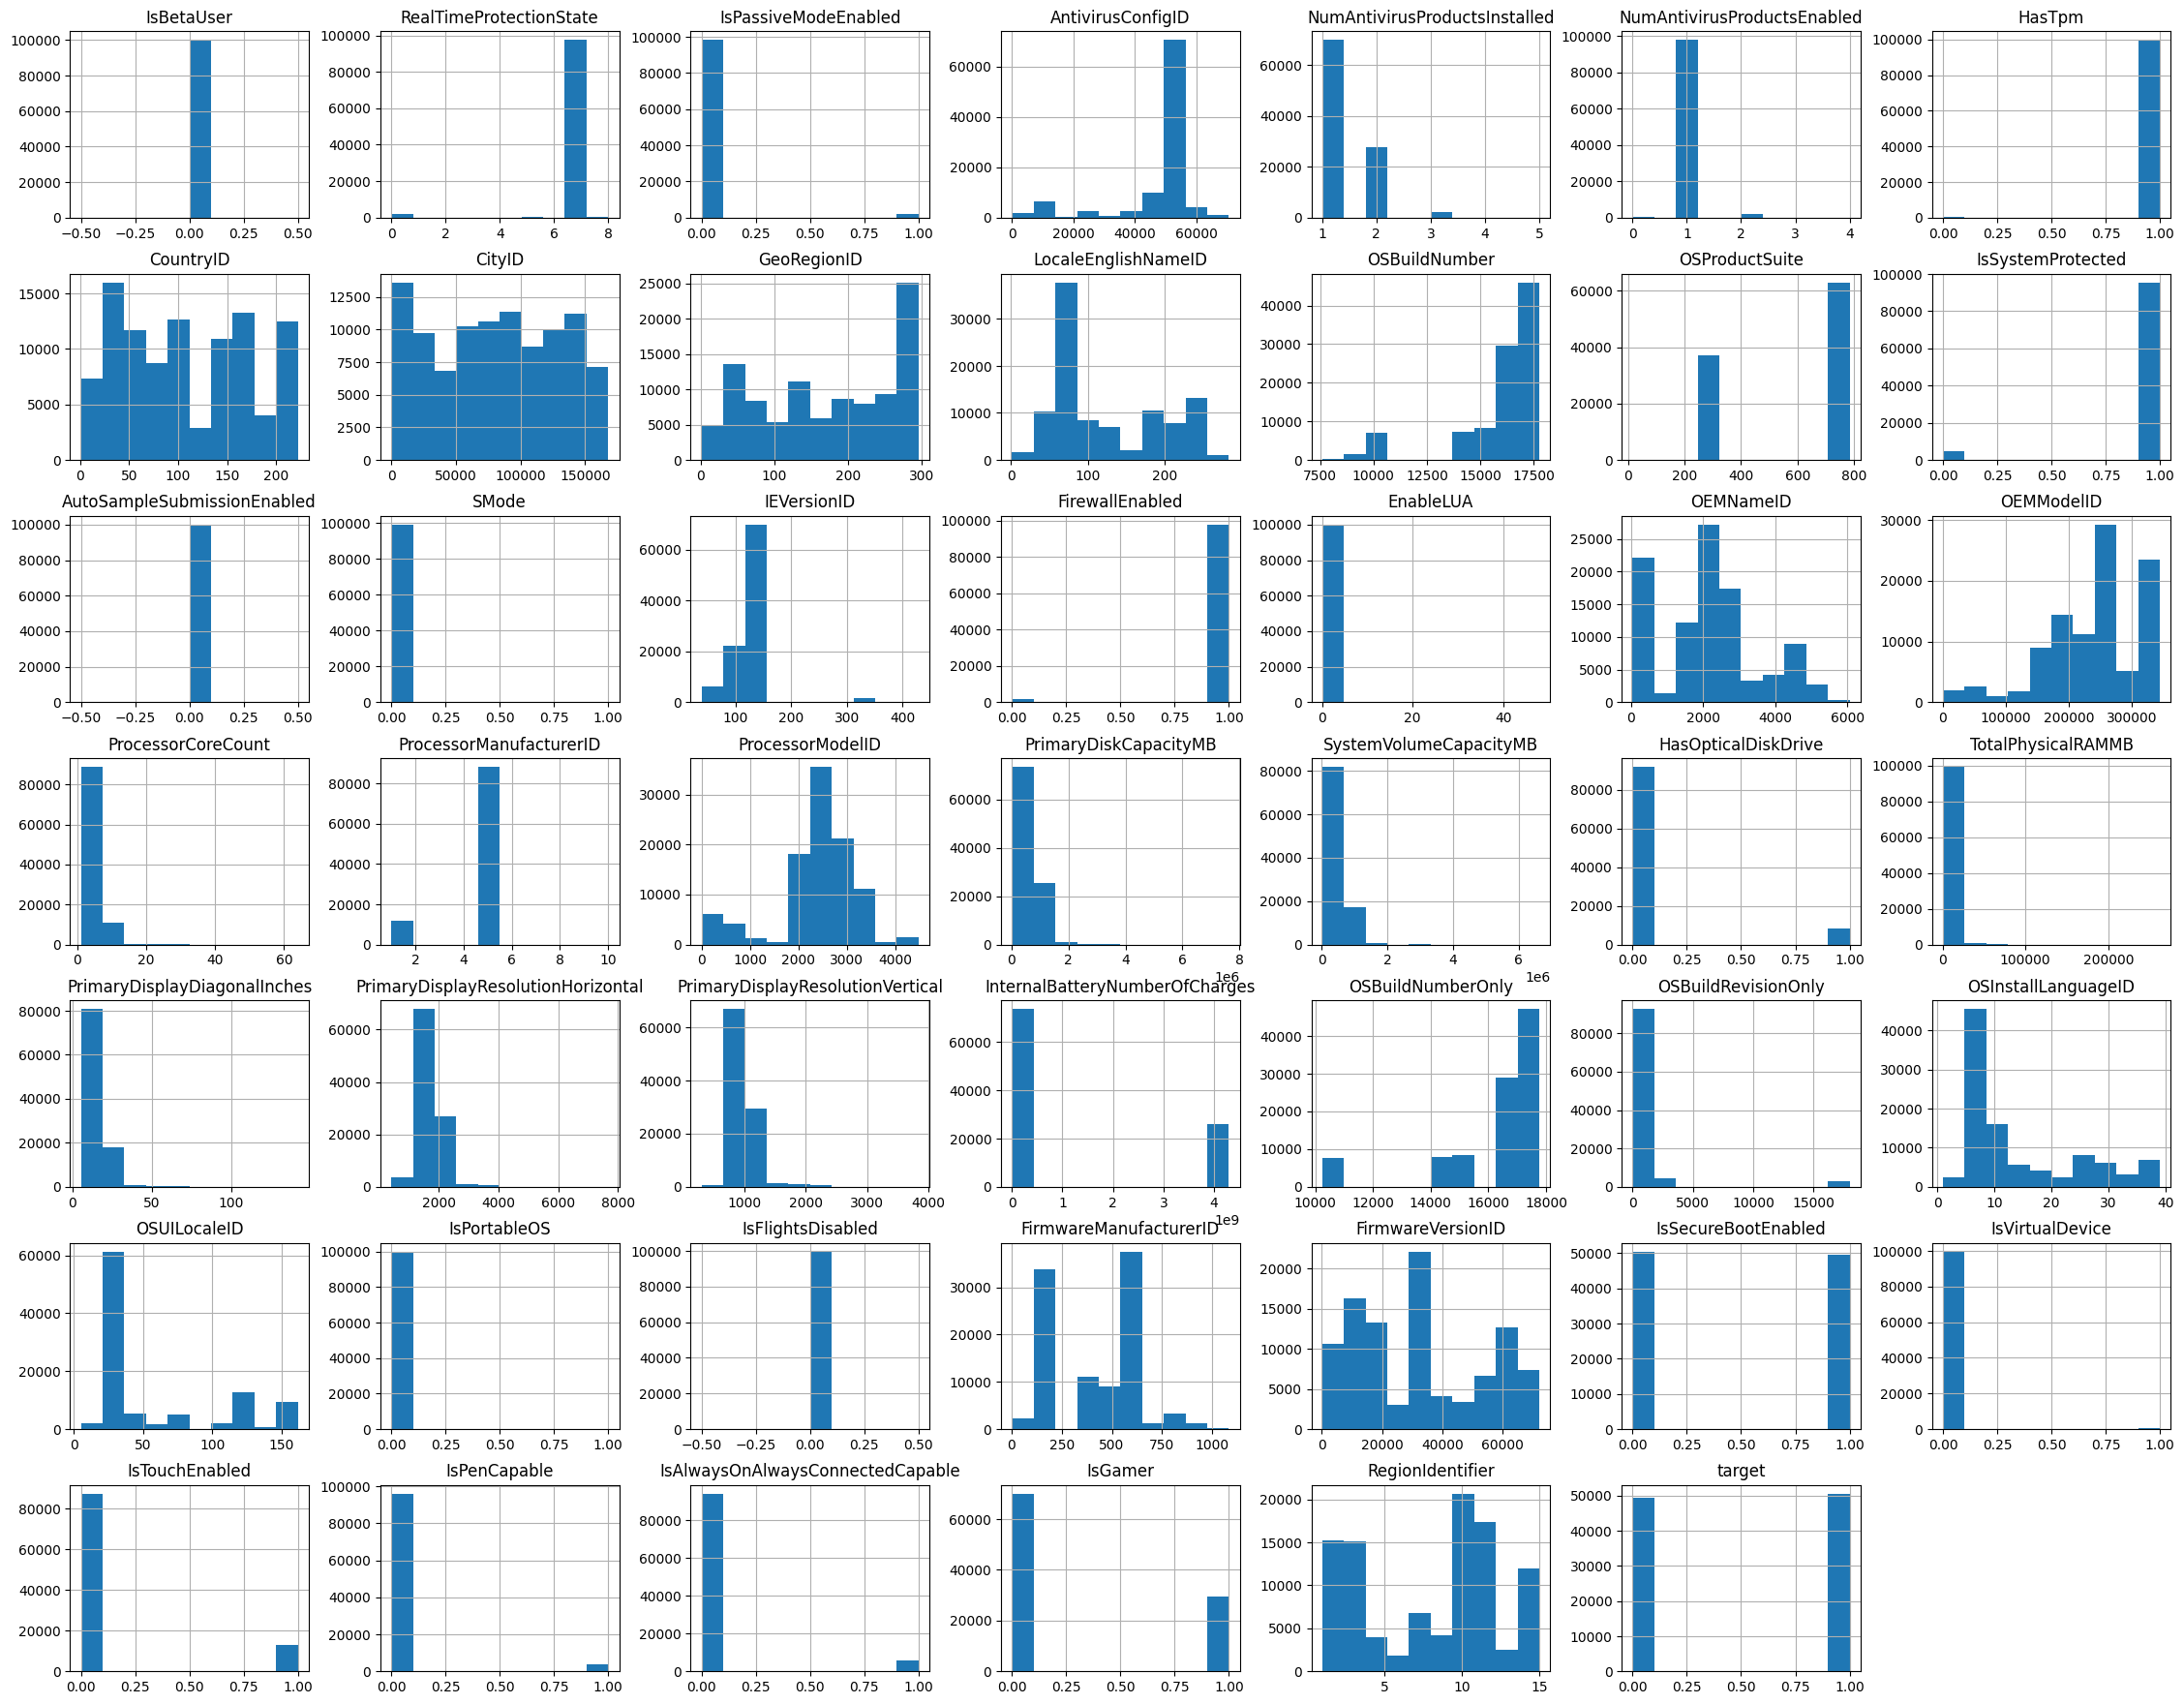

In [11]:
df_train.hist(figsize=(28,22))

1. **Distribution Analysis of Key Features (RealTimeProtectionState, PrimaryDiskCapacityMB, etc.)**
2. **Relationship Between Features (PrimaryDiskCapacityMB & SystemVolumeCapacityMB, etc.)**
3. **Analysis of Binary Features (HasTpm, IsSecureBootEnabled, etc.)**
4. **Geographic and Regional Insights (CountryID, GeoRegionID, etc.)**

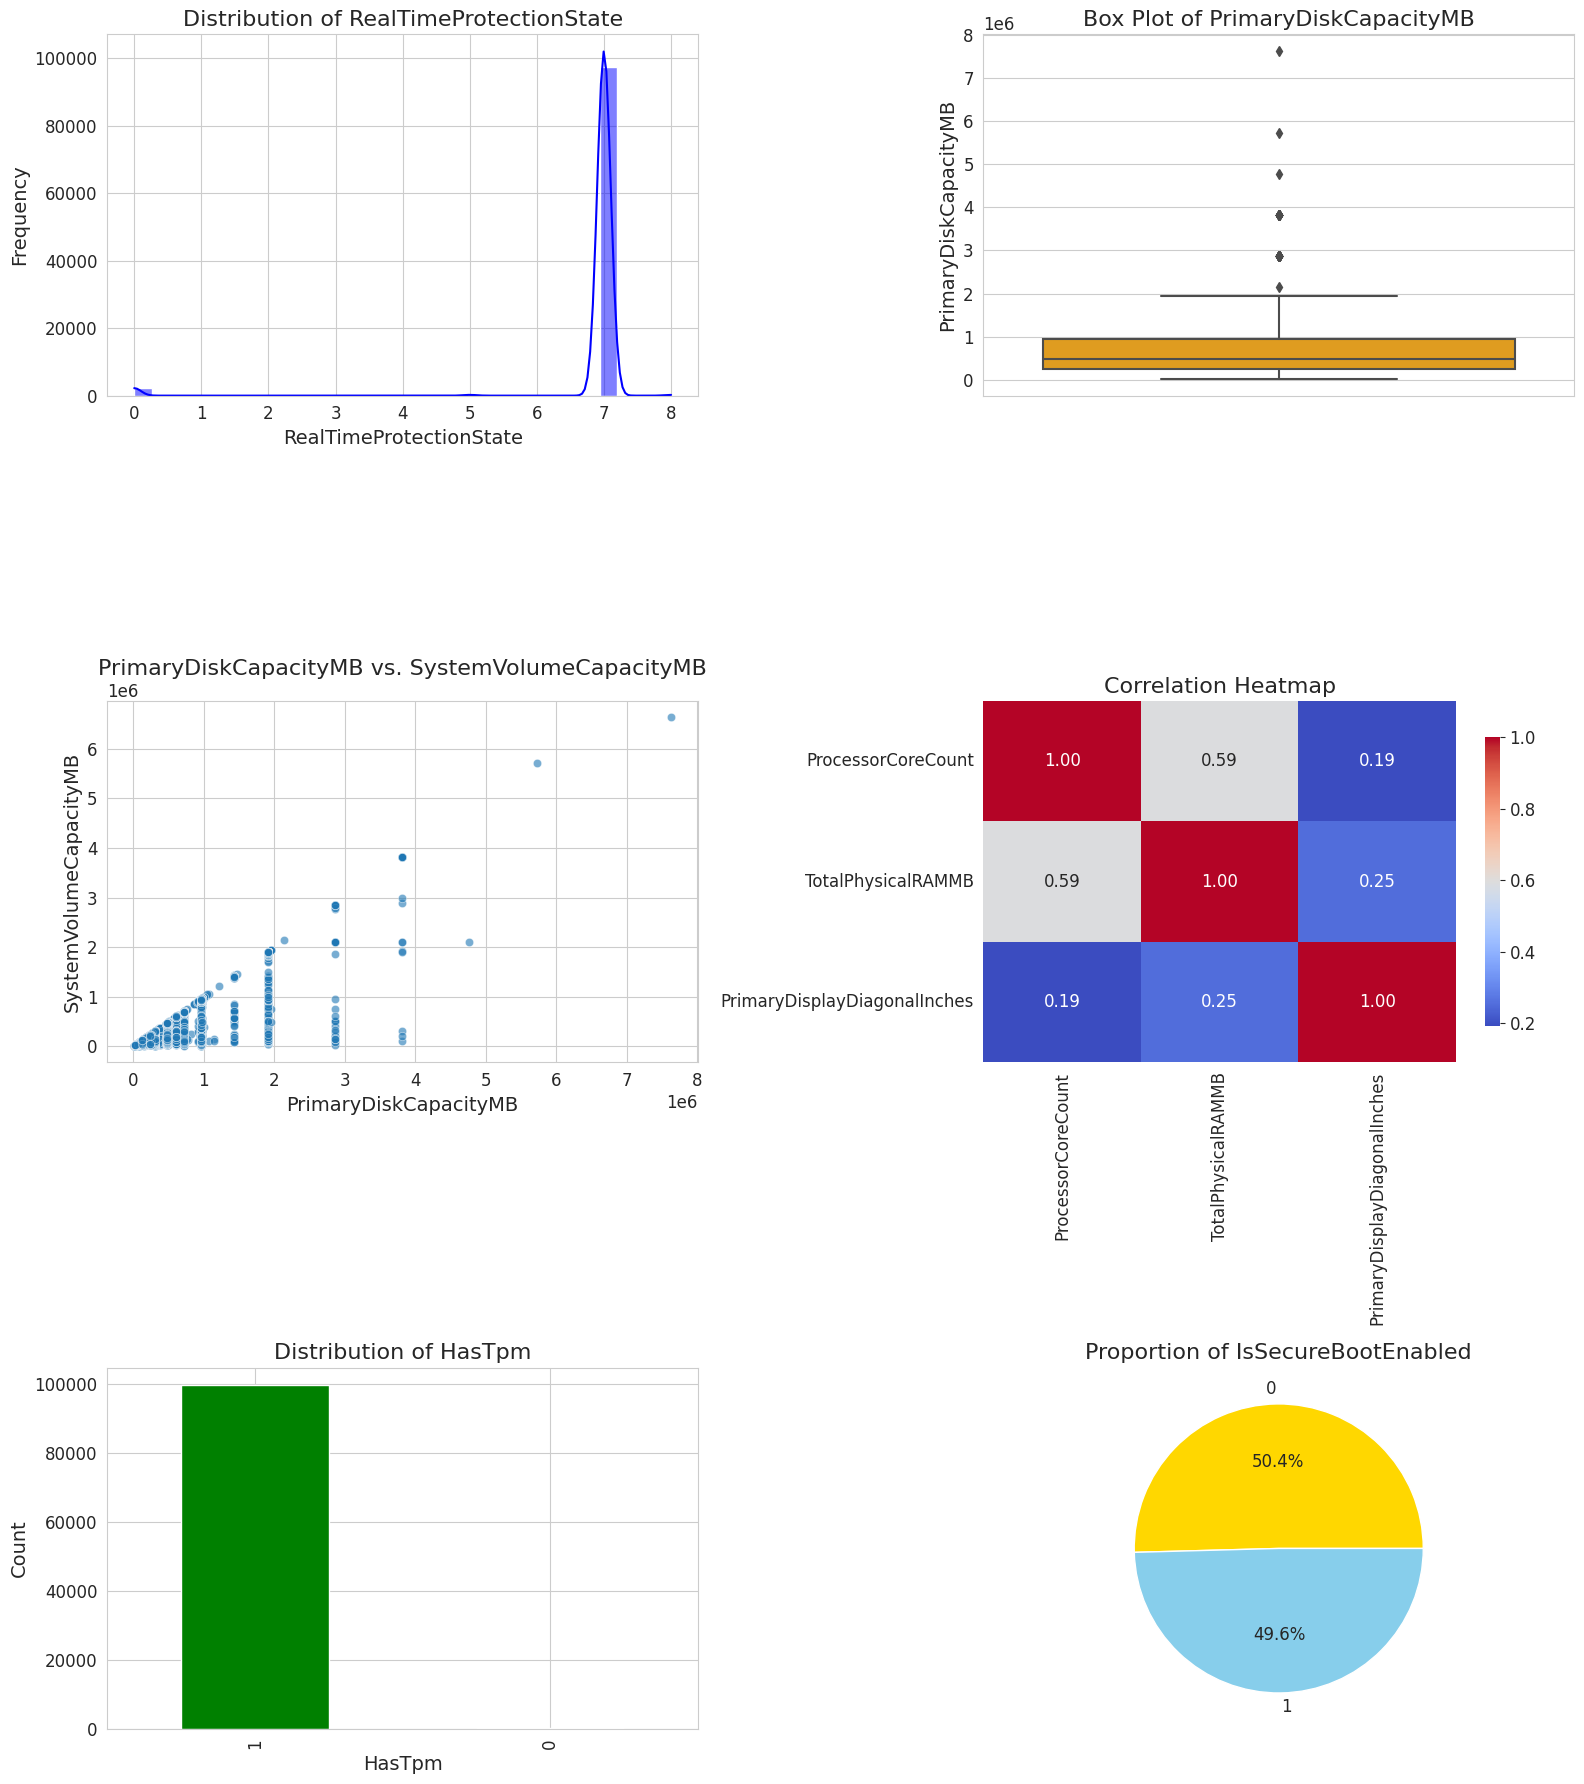

In [12]:
warnings.simplefilter(action='ignore', category=FutureWarning)


sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 12, 'axes.titlesize': 16, 'axes.labelsize': 14})


fig, axes = plt.subplots(3, 2, figsize=(16, 18)) 



# Histogram for RealTimeProtectionState
sns.histplot(df_train['RealTimeProtectionState'], kde=True, bins=30, color='blue', ax=axes[0, 0])
axes[0, 0].set_title('Distribution of RealTimeProtectionState')
axes[0, 0].set_xlabel('RealTimeProtectionState')
axes[0, 0].set_ylabel('Frequency')



# Box Plot for PrimaryDiskCapacityMB
sns.boxplot(y=df_train['PrimaryDiskCapacityMB'], color='orange', ax=axes[0, 1])
axes[0, 1].set_title('Box Plot of PrimaryDiskCapacityMB')
axes[0, 1].set_ylabel('PrimaryDiskCapacityMB')




# Scatter Plot for PrimaryDiskCapacityMB vs. SystemVolumeCapacityMB
sns.scatterplot(x=df_train['PrimaryDiskCapacityMB'], y=df_train['SystemVolumeCapacityMB'], alpha=0.6, ax=axes[1, 0])
axes[1, 0].set_title('PrimaryDiskCapacityMB vs. SystemVolumeCapacityMB')
axes[1, 0].set_xlabel('PrimaryDiskCapacityMB')
axes[1, 0].set_ylabel('SystemVolumeCapacityMB')




# Heatmap for Correlations
correlation_matrix = df_train[['ProcessorCoreCount', 'TotalPhysicalRAMMB', 'PrimaryDisplayDiagonalInches']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', ax=axes[1, 1], cbar_kws={'shrink': 0.8})
axes[1, 1].set_title('Correlation Heatmap')




# Bar Chart for HasTpm
tpm_counts = df_train['HasTpm'].value_counts()
tpm_counts.plot(kind='bar', color=['green', 'red'], ax=axes[2, 0])
axes[2, 0].set_title('Distribution of HasTpm')
axes[2, 0].set_xlabel('HasTpm')
axes[2, 0].set_ylabel('Count')





# Pie Chart for IsSecureBootEnabled
secure_boot_counts = df_train['IsSecureBootEnabled'].value_counts()
secure_boot_counts.plot.pie(autopct='%1.1f%%', colors=['gold', 'skyblue'], ax=axes[2, 1])
axes[2, 1].set_title('Proportion of IsSecureBootEnabled')
axes[2, 1].set_ylabel('')  


plt.tight_layout()
plt.show()

<!-- 5. **Target Variable Analysis (target, OSBuildNumber, etc.)**
6. **Outliers and Anomalies Detection (InternalBatteryNumberOfCharges, OSBuildRevisionOnly, etc.)**
7. **Trends and Aggregated Analysis (OSBuildNumber, ProcessorCoreCount, etc.)** -->

In [13]:
# sns.set_style('whitegrid')
# plt.rcParams.update({'font.size': 12, 'axes.titlesize': 16, 'axes.labelsize': 14})

# fig, axes = plt.subplots(4, 2, figsize=(18, 24)) 



# # Geographic Heatmap for CountryID
# sns.histplot(df_train['CountryID'], kde=False, bins=50, color='purple', ax=axes[0, 0])
# axes[0, 0].set_title('Distribution of CountryID')
# axes[0, 0].set_xlabel('CountryID')
# axes[0, 0].set_ylabel('Frequency')




# # Cluster Map for CountryID and GeoRegionID
# geo_data = df_train.groupby(['CountryID', 'GeoRegionID']).size().unstack(fill_value=0)
# sns.heatmap(geo_data, cmap='viridis', ax=axes[0, 1], cbar_kws={'shrink': 0.8})
# axes[0, 1].set_title('Cluster Map of CountryID and GeoRegionID')




# # Bar Chart for Target Variable
# target_counts = df_train['target'].value_counts()
# target_counts.plot(kind='bar', color=['blue', 'orange'], ax=axes[1, 0])
# axes[1, 0].set_title('Distribution of Target Variable')
# axes[1, 0].set_xlabel('Target')
# axes[1, 0].set_ylabel('Count')




# # Violin Plot for OSBuildNumber vs. Target
# sns.violinplot(x='target', y='OSBuildNumber', data=df_train, palette='muted', ax=axes[1, 1])
# axes[1, 1].set_title('OSBuildNumber by Target')
# axes[1, 1].set_xlabel('Target')
# axes[1, 1].set_ylabel('OSBuildNumber')




# # Box Plot for InternalBatteryNumberOfCharges
# sns.boxplot(y=df_train['InternalBatteryNumberOfCharges'], color='cyan', ax=axes[2, 0])
# axes[2, 0].set_title('Box Plot of InternalBatteryNumberOfCharges')
# axes[2, 0].set_ylabel('InternalBatteryNumberOfCharges')




# # Strip Plot for PrimaryDisplayDiagonalInches
# sns.stripplot(x='target', y='PrimaryDisplayDiagonalInches', data=df_train, jitter=True, palette='Set2', ax=axes[2, 1])
# axes[2, 1].set_title('PrimaryDisplayDiagonalInches by Target')
# axes[2, 1].set_xlabel('Target')
# axes[2, 1].set_ylabel('PrimaryDisplayDiagonalInches')




# # Line Chart for OSBuildNumber Trend
# os_build_trend = df_train.groupby('OSBuildNumber')['target'].mean()
# os_build_trend.plot(kind='line', color='magenta', ax=axes[3, 0])
# axes[3, 0].set_title('Trend of OSBuildNumber and Target')
# axes[3, 0].set_xlabel('OSBuildNumber')
# axes[3, 0].set_ylabel('Mean Target Value')





# # Bar Chart for ProcessorCoreCount
# core_counts = df_train['ProcessorCoreCount'].value_counts().sort_index()
# core_counts.plot(kind='bar', color='teal', ax=axes[3, 1])
# axes[3, 1].set_title('Distribution of ProcessorCoreCount')
# axes[3, 1].set_xlabel('ProcessorCoreCount')
# axes[3, 1].set_ylabel('Count')




# # Scatter Plot for Outliers in ProcessorCoreCount vs. Target
# plt.figure(figsize=(8, 6))
# sns.scatterplot(x='ProcessorCoreCount', y='TotalPhysicalRAMMB', hue='target', data=df_train, palette='cool')
# plt.title('Outlier Detection: ProcessorCoreCount vs TotalPhysicalRAMMB')
# plt.xlabel('ProcessorCoreCount')
# plt.ylabel('TotalPhysicalRAMMB')
# plt.show()





# plt.tight_layout()
# plt.show()

**KEY POINTS:**

- **RealTimeProtectionState:** The majority of systems have real-time protection enabled, indicating good security practices.
- **PrimaryDiskCapacityMB:** Disk sizes show a wide variation with some extremely high values, as highlighted by the box plot.
- **PrimaryDiskCapacityMB vs SystemVolumeCapacityMB:** A positive correlation exists between disk capacity and system volume capacity, though some outliers are present.
- **Correlation Heatmap:** **ProcessorCoreCount**, **TotalPhysicalRAMMB**, and **PrimaryDisplayDiagonalInches** have moderate correlations with each other, suggesting related hardware performance.
- **HasTpm:** Nearly all devices have TPM enabled, indicating strong hardware security support.
- **IsSecureBootEnabled:** Approximately 50% of systems have secure boot enabled, highlighting a security gap.
- **CountryID Distribution:** A few countries dominate the dataset, while others are sparsely represented.
- **CountryID vs. GeoRegionID:** Clear clustering patterns exist between **CountryID** and **GeoRegionID**, indicating region-specific data trends.
- **Target Variable:** The dataset has a balanced target variable distribution, essential for unbiased model training.
- **OSBuildNumber vs. Target:** The violin plot reveals some variance in **OSBuildNumber** values for both target classes, suggesting its potential importance in prediction.
- **InternalBatteryNumberOfCharges:** A significant spread in battery charges suggests varied device usage patterns.
- **PrimaryDisplayDiagonalInches:** Display size is fairly consistent across both target classes with slight variations.
- **OSBuildNumber Trend:** A noticeable trend exists where certain OS build numbers show varying success rates in the target variable.
- **ProcessorCoreCount:** Most systems have 4 cores, but outliers with up to 64 cores were detected.
- **ProcessorCoreCount vs. TotalPhysicalRAMMB:** Outliers were detected where systems with high core counts did not have proportionally higher RAM.


# **Data Cleaning/ Preprocessing**

**Data Overview:**
* Total Rows:-- 100,000
* Total Columns:-- 76
* Duplicates:-- 165 rows
* Missing Values:-- Several columns have missing values, with a maximum of 559 missing entries in IsGamer and RegionIdentifier
  
**Observations:**
* Numerical Features:-- Columns like RealTimeProtectionState, NumAntivirusProductsInstalled, and PrimaryDiskCapacityMB are numerical and need scaling
* Categorical Features:-- Columns like PlatformType, Processor, and DeviceFamily need encoding
* Datetime Columns:-- DateAS and DateOS are datetime fields that may require conversion
* Target Column:-- target is the label for classification tasks

# Handle Missing Values

,Missing Values,Percentage
SMode,981,0.98%
CityID,623,0.62%
RegionIdentifier,559,0.56%
IsGamer,559,0.56%
InternalBatteryNumberOfCharges,515,0.52%
FirmwareManufacturerID,376,0.38%
FirmwareVersionID,334,0.33%
IsFlightsDisabled,326,0.33%
OEMModelID,228,0.23%
OEMNameID,212,0.21%


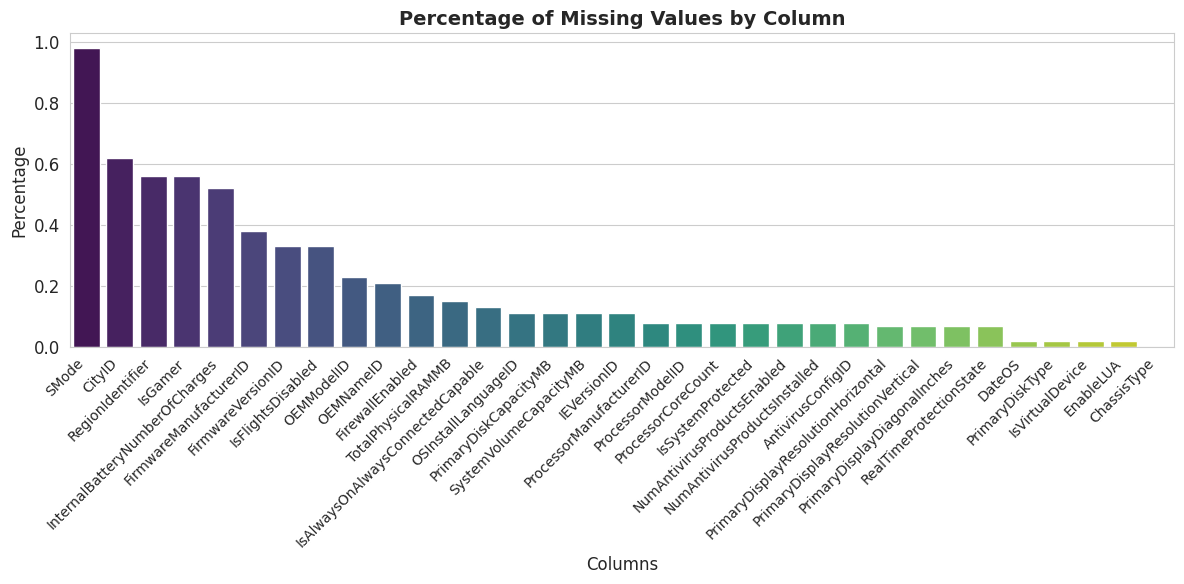

In [14]:
missing_values = df_train.isnull().sum().sort_values(ascending=False)
missing_percentage = (missing_values / len(df_train)) * 100


missing_summary = pd.DataFrame({
    "Missing Values": missing_values,
    
    "Percentage": missing_percentage
})


missing_summary = missing_summary[missing_summary["Missing Values"] > 0]


missing_summary["Percentage"] = missing_summary["Percentage"].map("{:.2f}%".format)


try:
    get_ipython() 
    display(
        missing_summary.style.set_caption("Missing Values Summary").set_table_styles(
            [{'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold')]}]
        )
    )
except NameError:
    from tabulate import tabulate
    print(tabulate(missing_summary, headers='keys', tablefmt='grid'))


plt.figure(figsize=(12, 6))
sns.barplot(
    x=missing_summary.index,
    y=missing_summary["Percentage"].str.rstrip('%').astype(float),  
    palette="viridis"
)
plt.title("Percentage of Missing Values by Column", fontsize=14, fontweight='bold')
plt.xlabel("Columns", fontsize=12)
plt.ylabel("Percentage", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.show()

In [15]:
num_cols = df_train.select_dtypes(include=['float64', 'int64']).columns.drop('target')
cat_cols = df_train.select_dtypes(include=['object']).columns



num_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='most_frequent')




df_train[num_cols] = num_imputer.fit_transform(df_train[num_cols])
df_train[cat_cols] = cat_imputer.fit_transform(df_train[cat_cols])





df_test[num_cols] = num_imputer.transform(df_test[num_cols])
df_test[cat_cols] = cat_imputer.transform(df_test[cat_cols])





print("\nMissing Values After Imputation in Train Data:", df_train.isnull().sum().sum())
print("\nMissing Values After Imputation in Test Data:", df_test.isnull().sum().sum())



Missing Values After Imputation in Train Data: 0

Missing Values After Imputation in Test Data: 0


# **Feature Correlation Map: Insights at a Glance**

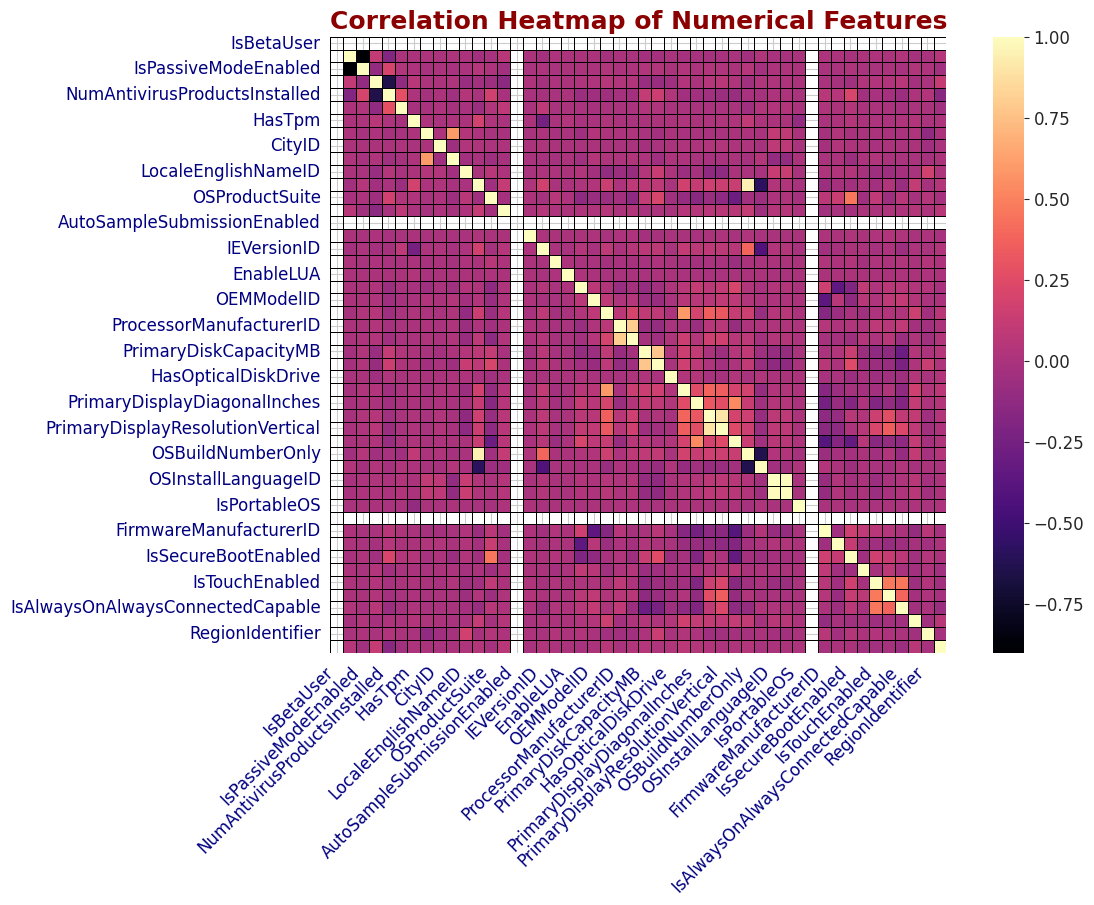

In [16]:
df_numeric = df_train.select_dtypes(include=[float, int])
correlation_matrix = df_numeric.corr()


plt.figure(figsize=(12, 8))
sns.heatmap(
    correlation_matrix, 
    annot=False,  
    cmap="magma", 
    cbar=True,  
    linewidths=0.7, 
    linecolor="black",  
    square=True
)



plt.title("Correlation Heatmap of Numerical Features", fontsize=18, fontweight="bold", color="darkred")
plt.xticks(rotation=45, ha="right", fontsize=12, fontweight="medium", color="navy")
plt.yticks(fontsize=12, fontweight="medium", color="navy")

plt.show()


# **Feature Distribution Across Target Classes**

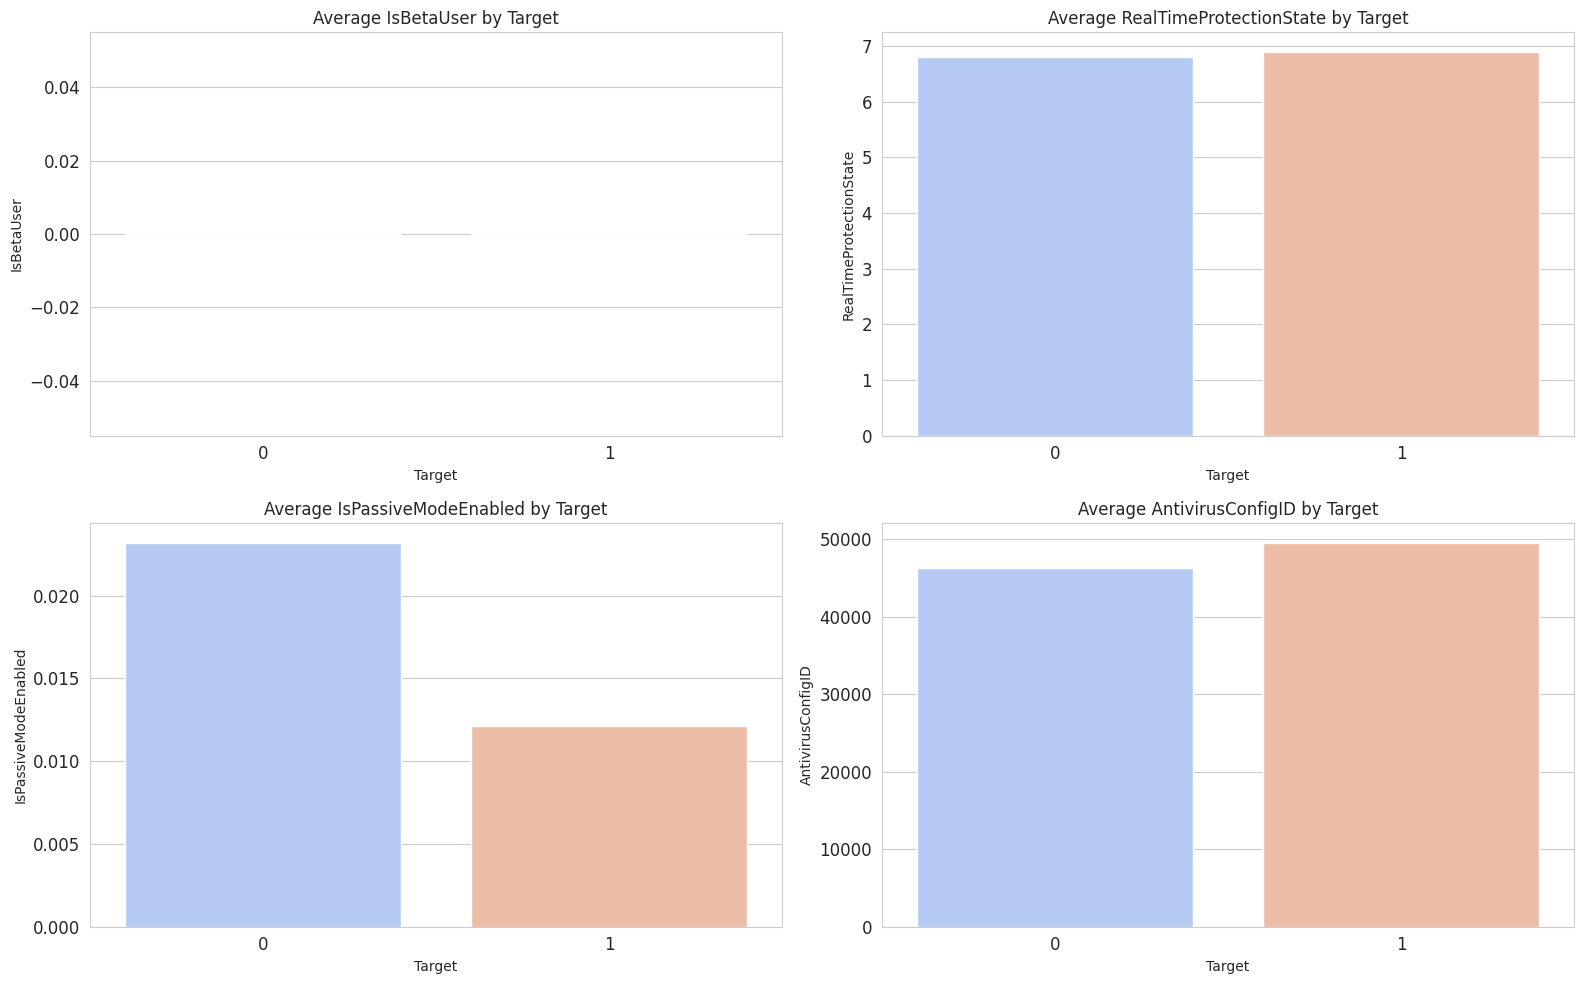

In [17]:
numeric_features = df_train.select_dtypes(include=[float, int]).columns.tolist()
selected_features = numeric_features[:4] 


plt.figure(figsize=(16, 10))

for i, feature in enumerate(selected_features, 1):
    plt.subplot(2, 2, i) 
    sns.barplot(data=df_train, x="target", y=feature, palette="coolwarm", errorbar=None)
    plt.title(f"Average {feature} by Target", fontsize=12)
    plt.xlabel("Target", fontsize=10)
    plt.ylabel(feature, fontsize=10)

plt.tight_layout()
plt.show()

**FEATURE ENGINEERING/EXTRACTION (on datetime)**

In [18]:
date_columns = ['DateAS', 'DateOS']
for col in date_columns:
    df_train[col] = pd.to_datetime(df_train[col], errors='coerce') 
    df_train[f"{col}_year"] = df_train[col].dt.year
    df_train[f"{col}_month"] = df_train[col].dt.month
    df_train[f"{col}_day"] = df_train[col].dt.day
    df_train.drop(columns=[col], inplace=True)

**Test Data**

In [19]:
date_columns = ['DateAS', 'DateOS']
for col in date_columns:
    df_test[col] = pd.to_datetime(df_test[col], errors='coerce') 
    df_test[f"{col}_year"] = df_test[col].dt.year
    df_test[f"{col}_month"] = df_test[col].dt.month
    df_test[f"{col}_day"] = df_test[col].dt.day
    df_test.drop(columns=[col], inplace=True) 

# Scale Numerical Features

In [20]:
numerical_columns_to_scale = [
    'PrimaryDiskCapacityMB', 'SystemVolumeCapacityMB', 
    'OEMModelID', 'TotalPhysicalRAMMB',
    'FirmwareVersionID', 'AntivirusConfigID', 
    'OSBuildRevisionOnly', 'ProcessorModelID'
]


scaler = StandardScaler()



df_train[numerical_columns_to_scale] = scaler.fit_transform(df_train[numerical_columns_to_scale])


df_test[numerical_columns_to_scale] = scaler.transform(df_test[numerical_columns_to_scale])



print("\nScaled Train Data:\n", df_train[numerical_columns_to_scale].head())
print("\nScaled Test Data:\n", df_test[numerical_columns_to_scale].head())


Scaled Train Data:
    PrimaryDiskCapacityMB  SystemVolumeCapacityMB  OEMModelID  TotalPhysicalRAMMB  FirmwareVersionID  AntivirusConfigID  OSBuildRevisionOnly  ProcessorModelID
0            -1.4213e+00             -1.1331e+00  1.2787e+00         -1.0619e+00        -5.1991e-01         3.9653e-01           4.1309e-01       -6.1817e-01
1             1.2430e+00              1.7587e+00 -2.9817e+00         -4.2328e-01         5.4959e-01         3.9653e-01          -2.5528e-01        4.6936e-02
2            -8.1428e-01             -4.7364e-01  3.4743e-01          4.2824e-01        -1.1142e+00         3.9653e-01          -2.3609e-01        4.1949e-01
3             3.9501e+00              4.6504e+00  5.1798e-02          4.2824e-01         5.5574e-03        -1.1326e-01          -4.5948e-02        1.2446e+00
4            -5.9772e-01             -1.0146e+00  2.5868e-01         -8.4904e-01        -9.3380e-01        -5.4426e-01          -2.3609e-01        2.3336e+00

Scaled Test Data:
    PrimaryD

# Encode Categorical Features

In [21]:
columns_to_encode = ['PlatformType', 'Processor', 'OsPlatformSubRelease', 'SKUEditionName', 'MDC2FormFactor', 'DeviceFamily',
                     'PrimaryDiskType', 'ChassisType', 'PowerPlatformRole', 'OSArchitecture', 'OSEdition', 'OSInstallType', 
                     'AutoUpdateOptionsName', 'OSGenuineState', 'LicenseActivationChannel', 'FlightRing', 'ProductName']



columns_to_delete = ['MachineID', 'IsBetaUser', 'OSBuildLab', 'NumericOSVersion', 'OSBranch',
                     'OSSkuFriendlyName', 'ProductName', 'LocaleEnglishNameID', 'AutoSampleSubmissionEnabled', 
                     'InternalBatteryNumberOfCharges', 'IsFlightsDisabled', 'FirmwareManufacturerID', 'RegionIdentifier', 'OEMNameID']



columns_to_convert_to_int = ['EngineVersion', 'AppVersion', 'SignatureVersion', 'OSVersion']


label_encoders = {}  
for col in columns_to_encode:
    le = LabelEncoder()
    df_train[col] = le.fit_transform(df_train[col].astype(str))  
    df_test[col] = le.transform(df_test[col].astype(str))  
    label_encoders[col] = le  
    



df_train.drop(columns=columns_to_delete, inplace=True)
df_test.drop(columns=columns_to_delete, inplace=True)



for col in columns_to_convert_to_int:
    
    df_train[col] = df_train[col].fillna('').astype(str)
    df_test[col] = df_test[col].fillna('').astype(str)


    
    for df in [df_train, df_test]:
        version_parts = df[col].str.split('.', expand=True)
        col_names = ['Major', 'Minor', 'Build', 'Revision']

        for i in range(4):
            part_col = f'{col}_{col_names[i]}'
            if i < version_parts.shape[1]:
                df[part_col] = pd.to_numeric(version_parts[i], errors='coerce').fillna(0).astype(int)
            else:
                df[part_col] = 0  

    
        df.drop(columns=[col], inplace=True)



print("\nProcessed Train Data:\n", df_train.head())
print("\nProcessed Test Data:\n", df_test.head())


Processed Train Data:
    RealTimeProtectionState  IsPassiveModeEnabled  AntivirusConfigID  NumAntivirusProductsInstalled  NumAntivirusProductsEnabled     HasTpm  CountryID     CityID  GeoRegionID  PlatformType  Processor  OSBuildNumber  OSProductSuite  OsPlatformSubRelease  SKUEditionName  IsSystemProtected      SMode  IEVersionID  FirewallEnabled  EnableLUA  MDC2FormFactor  DeviceFamily  OEMModelID  ProcessorCoreCount  ProcessorManufacturerID  ProcessorModelID  PrimaryDiskCapacityMB  PrimaryDiskType  SystemVolumeCapacityMB  HasOpticalDiskDrive  TotalPhysicalRAMMB  ChassisType  PrimaryDisplayDiagonalInches  PrimaryDisplayResolutionHorizontal  PrimaryDisplayResolutionVertical  PowerPlatformRole  OSArchitecture  OSBuildNumberOnly  OSBuildRevisionOnly  OSEdition  OSInstallType  OSInstallLanguageID  OSUILocaleID  AutoUpdateOptionsName  IsPortableOS  OSGenuineState  LicenseActivationChannel  FlightRing  FirmwareVersionID  IsSecureBootEnabled  IsVirtualDevice  IsTouchEnabled  IsPenCapable 

In [22]:
correlation_matrix = df_train.corr().abs()



upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
highly_correlated_features = [col for col in upper_triangle.columns if any(upper_triangle[col] > 0.9)]



df_train.drop(columns=highly_correlated_features, inplace=True)
df_test.drop(columns=highly_correlated_features, inplace=True, errors='ignore')  




print("\nFeatures removed due to high correlation:", highly_correlated_features)
print("Shape of Train Data After Feature Selection:", df_train.shape)
print("Shape of Test Data After Feature Selection:", df_test.shape)


Features removed due to high correlation: ['IsPassiveModeEnabled', 'OSArchitecture', 'OSBuildNumberOnly', 'OSEdition', 'OSUILocaleID', 'SignatureVersion_Minor', 'OSVersion_Major', 'OSVersion_Minor']
Shape of Train Data After Feature Selection: (100000, 70)
Shape of Test Data After Feature Selection: (10000, 69)


# Cleaning Test Data Before Predictions

In [23]:
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# from sklearn.impute import SimpleImputer
# import pandas as pd
# import numpy as np


# date_columns = ['DateAS', 'DateOS']
# numerical_columns_to_scale = [
#     'PrimaryDiskCapacityMB', 'SystemVolumeCapacityMB', 
#     'OEMModelID', 'TotalPhysicalRAMMB',
#     'FirmwareVersionID', 'AntivirusConfigID', 
#     'OSBuildRevisionOnly', 'ProcessorModelID',
# ]
# columns_to_encode = ['PlatformType', 'Processor', 'OsPlatformSubRelease', 'SKUEditionName', 'MDC2FormFactor', 'DeviceFamily',
#                      'PrimaryDiskType', 'ChassisType', 'PowerPlatformRole', 'OSArchitecture', 'OSEdition', 'OSInstallType',
#                      'AutoUpdateOptionsName', 'OSGenuineState', 'LicenseActivationChannel', 'FlightRing', 'ProductName']
# columns_to_delete = ['MachineID', 'IsBetaUser', 'OSBuildLab', 'NumericOSVersion', 'OSBranch',
#                      'OSSkuFriendlyName', 'ProductName', 'LocaleEnglishNameID', 'AutoSampleSubmissionEnabled',
#                      'InternalBatteryNumberOfCharges', 'IsFlightsDisabled', 'FirmwareManufacturerID', 'RegionIdentifier', 'OEMNameID']
# columns_to_convert_to_int = ['EngineVersion', 'AppVersion', 'SignatureVersion', 'OSVersion']



# # Handle missing values
# num_cols = df_test.select_dtypes(include=['float64', 'int64']).columns
# cat_cols = df_test.select_dtypes(include=['object']).columns

# num_imputer = SimpleImputer(strategy='mean')
# cat_imputer = SimpleImputer(strategy='most_frequent')

# df_test[num_cols] = num_imputer.fit_transform(df_test[num_cols])
# df_test[cat_cols] = cat_imputer.fit_transform(df_test[cat_cols])

# print("\nMissing Values After Imputation in Test Data:", df_test.isnull().sum().sum())




# # Handling date columns
# for col in date_columns:
#     df_test[col] = pd.to_datetime(df_test[col], errors='coerce') 
#     df_test[f"{col}_year"] = df_test[col].dt.year
#     df_test[f"{col}_month"] = df_test[col].dt.month
#     df_test[f"{col}_day"] = df_test[col].dt.day
#     df_test.drop(columns=[col], inplace=True)




# # Standardizing numerical features
# existing_numerical_columns = [col for col in numerical_columns_to_scale if col in df_test.columns]
# df_test[existing_numerical_columns] = df_test[existing_numerical_columns].apply(pd.to_numeric, errors='coerce')
# df_test[existing_numerical_columns] = df_test[existing_numerical_columns].fillna(df_test[existing_numerical_columns].mean())

# scaler = StandardScaler()
# df_test[existing_numerical_columns] = scaler.fit_transform(df_test[existing_numerical_columns])




# # Labeling Encoding
# label_encoder = LabelEncoder()
# for col in columns_to_encode:
#     df_test[col] = df_test[col].astype(str)
#     df_test[col] = label_encoder.fit_transform(df_test[col])




# # Dropping unnecessary columns
# df_test.drop(columns=columns_to_delete, inplace=True, errors='ignore')




# # Converting version columns to integers
# for col in columns_to_convert_to_int:
#     df_test[col] = df_test[col].fillna('').astype(str)
#     version_parts = df_test[col].str.split('.', expand=True)
    
#     col_names = ['Major', 'Minor', 'Build', 'Revision']
#     for i in range(4):
#         part_col = f'{col}_{col_names[i]}'
#         if i < version_parts.shape[1]:
#             df_test[part_col] = pd.to_numeric(version_parts[i], errors='coerce').fillna(0).astype(int)
#         else:
#             df_test[part_col] = 0 
#     df_test.drop(columns=[col], inplace=True)



# # Feature selection: Removing highly correlated features
# df_test.drop(columns=highly_correlated_features, inplace=True)



# print("\nFeatures removed due to high correlation:", highly_correlated_features)
# df_test.head()


# **Train-Validation Split**

In [24]:
X = df_train.drop('target', axis=1) 
y = df_train['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


print(f'Training set size: {X_train.shape}')
print(f'Validation set size: {X_val.shape}')
print(f'Test set size: {df_test.shape}')


print("""\nKey Points:
- train_test_split is used for splitting the data.
- test_size=0.2 indicates 80% for training and 20% for validation.
- The random_state ensures reproducibility.
- The test dataset (test.csv) remains untouched for final evaluation.
""")


Training set size: (80000, 69)
Validation set size: (20000, 69)
Test set size: (10000, 69)

Key Points:
- train_test_split is used for splitting the data.
- test_size=0.2 indicates 80% for training and 20% for validation.
- The random_state ensures reproducibility.
- The test dataset (test.csv) remains untouched for final evaluation.



# **Building a  baseline model**

# **Logistic Regression**

In [25]:
SCORES = {}
ERRORS = {}
SUBMISSIONS = {}

In [26]:
model = LogisticRegression()


model.fit(X_train, y_train)


y_predict = model.predict(X_val)


accuracy = accuracy_score(y_val, y_predict)
conf_matrix = confusion_matrix(y_val, y_predict)
class_report = classification_report(y_val, y_predict)


print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

SCORES['LogisticRegression'] = accuracy

Accuracy: 0.55
Confusion Matrix:
[[3547 6331]
 [2653 7469]]
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.36      0.44      9878
           1       0.54      0.74      0.62     10122

    accuracy                           0.55     20000
   macro avg       0.56      0.55      0.53     20000
weighted avg       0.56      0.55      0.53     20000



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# **Model Building**

# **Random Forest Classifier**


 Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.55      0.59      9878
           1       0.61      0.69      0.65     10122

    accuracy                           0.62     20000
   macro avg       0.62      0.62      0.62     20000
weighted avg       0.62      0.62      0.62     20000


 Model Accuracy: 0.6207


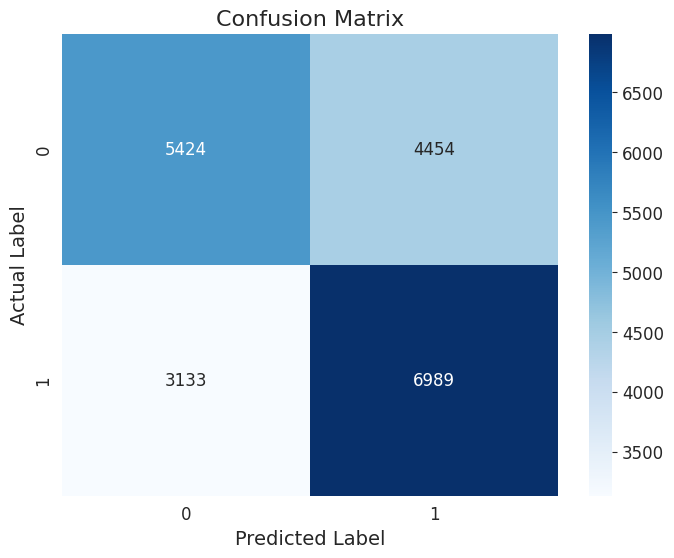

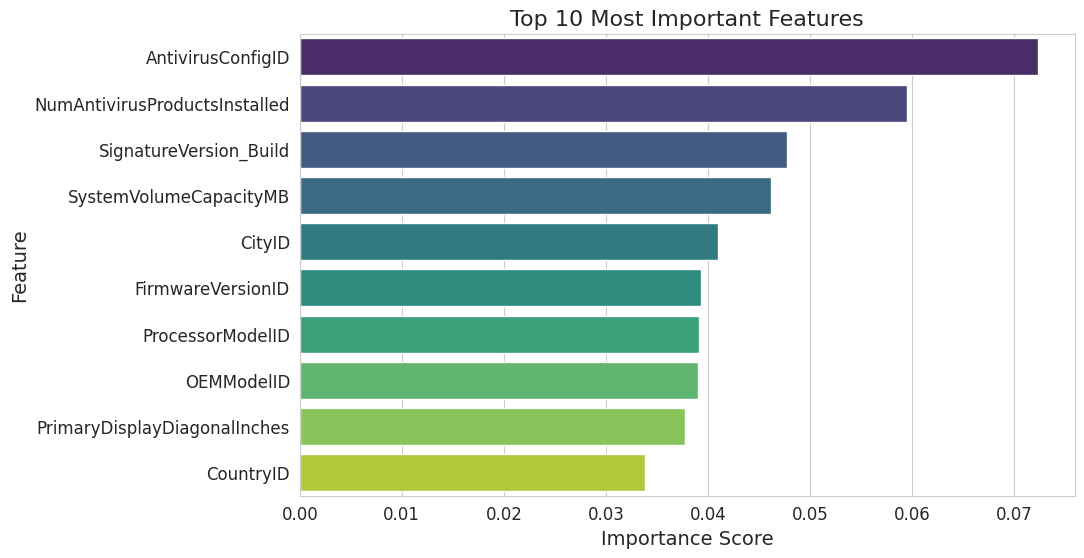

In [27]:
rf_model = RandomForestClassifier(
    n_estimators=100,      
    max_depth=15,           
    min_samples_split=8,    
    min_samples_leaf=4,    
    random_state=42,
    class_weight='balanced'
)


rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_val)


print("\n Classification Report:")
print(classification_report(y_val, y_pred))


accuracy = accuracy_score(y_val, y_pred)
print(f"\n Model Accuracy: {accuracy:.4f}")




plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()





feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)




plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature', palette='viridis')
plt.title("Top 10 Most Important Features")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


# **Stochastic Gradient Descent (SGD)**


 Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.59      0.55      9878
           1       0.54      0.46      0.50     10122

    accuracy                           0.53     20000
   macro avg       0.53      0.53      0.53     20000
weighted avg       0.53      0.53      0.53     20000


 Model Accuracy: 0.5283


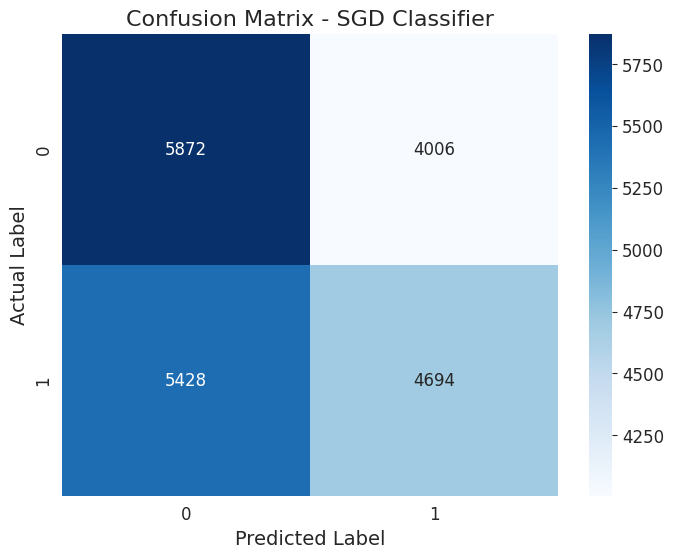

In [28]:
sgd_model = SGDClassifier(loss="log_loss", random_state=42)


sgd_model.fit(X_train, y_train)

y_pred = sgd_model.predict(X_val)


print("\n Classification Report:")
print(classification_report(y_val, y_pred))


accuracy = accuracy_score(y_val, y_pred)
print(f"\n Model Accuracy: {accuracy:.4f}")




plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - SGD Classifier")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()


# **Hyperparameter Tuning for SGD Classifier**

In [29]:
param_dist = {
    'loss': ['log_loss'],  
    'alpha': [0.01],  
    'penalty': ['l1'],  
    'max_iter': [1000]  
}


random_search = RandomizedSearchCV(
    SGDClassifier(random_state=42),
    param_dist,
    n_iter=10,  
    cv=3,  
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X_train, y_train)


print("\n Best Hyperparameters:", random_search.best_params_)
best_sgd_model = random_search.best_estimator_
y_pred_optimized = best_sgd_model.predict(X_val)


print("\n Classification Report (Optimized Model):")
print(classification_report(y_val, y_pred_optimized))
accuracy_optimized = accuracy_score(y_val, y_pred_optimized)
print(f"\n Optimized Model Accuracy: {accuracy_optimized:.4f}")


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



 Best Hyperparameters: {'penalty': 'l1', 'max_iter': 1000, 'loss': 'log_loss', 'alpha': 0.01}

 Classification Report (Optimized Model):
              precision    recall  f1-score   support

           0       0.49      0.99      0.66      9878
           1       0.58      0.01      0.02     10122

    accuracy                           0.50     20000
   macro avg       0.54      0.50      0.34     20000
weighted avg       0.54      0.50      0.34     20000


 Optimized Model Accuracy: 0.4953


# **XGBoost Classifier**

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.58      0.61      9878
           1       0.62      0.67      0.65     10122

    accuracy                           0.63     20000
   macro avg       0.63      0.63      0.63     20000
weighted avg       0.63      0.63      0.63     20000

Model Accuracy: 0.6294


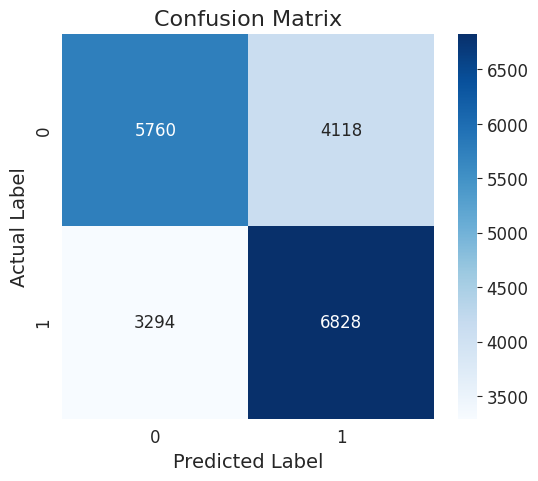

In [30]:
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)



param_dist = {
    'n_estimators': [100, 200],  
    'learning_rate': [0.05, 0.1],  
    'max_depth': [3, 6],  
    'subsample': [0.8, 1.0],  
    'colsample_bytree': [0.8, 1.0],  
}



random_search = RandomizedSearchCV(
    xgb_model, param_distributions=param_dist, 
    n_iter=5, cv=3, n_jobs=-1, verbose=1, random_state=42
)

random_search.fit(X_train, y_train)




best_xgb = random_search.best_estimator_
print("Best Hyperparameters:", random_search.best_params_)

y_pred = best_xgb.predict(X_val)



print("Classification Report:")
print(classification_report(y_val, y_pred))
accuracy = accuracy_score(y_val, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")


plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()


In [31]:
submission_df = pd.DataFrame({
    'id': range(0, df_test.shape[0]),  
    'target': best_xgb.predict(df_test)
})



submission_path = "xgb_submission.csv"
submission_df.to_csv(submission_path, index=False)

print(f"Submission file saved successfully as: {submission_path}")



Submission file saved successfully as: xgb_submission.csv


In [32]:
###BAGGING


bagging_model = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=10, random_state=42)
bagging_model.fit(X_train, y_train)
y_val_pred_bagging = bagging_model.predict(X_val)
print("Bagging Validation Accuracy:", accuracy_score(y_val, y_val_pred_bagging))




##BOOSTING

boosting_model = AdaBoostClassifier(n_estimators=50, random_state=42)
boosting_model.fit(X_train, y_train)
y_val_pred_boosting = boosting_model.predict(X_val)
print("Boosting Validation Accuracy:", accuracy_score(y_val, y_val_pred_boosting))



# ##STACKING


# stacking_model = StackingClassifier(
#     estimators=[
#         ('dt', DecisionTreeClassifier()),
#         ('svm', SVC(probability=True)),
#         ('gb', GradientBoostingClassifier())
#     ],
#     final_estimator=LogisticRegression(),
#     stack_method='auto'
# )
# stacking_model.fit(X_train, y_train)
# y_val_pred_stacking = stacking_model.predict(X_val)
# print("Stacking Validation Accuracy:", accuracy_score(y_val, y_val_pred_stacking))

# # Make predictions on df_test (final evaluation)
# df_test_predictions_bagging = bagging_model.predict(df_test)
# df_test_predictions_boosting = boosting_model.predict(df_test)
# df_test_predictions_stacking = stacking_model.predict(df_test)

# # Save predictions (optional)
# pd.DataFrame({
#     'Bagging': df_test_predictions_bagging,
#     'Boosting': df_test_predictions_boosting,
#     'Stacking': df_test_predictions_stacking
# }).to_csv("final_predictions.csv", index=False)

# print("\nPredictions saved to final_predictions.csv")


Bagging Validation Accuracy: 0.57235
Boosting Validation Accuracy: 0.6173


# **Milestone 1 Questions**

In [33]:


# # Calculate the 50th percentile (median) of "TotalPhysicalRAMMB"
# percentile_50 = df_train["TotalPhysicalRAMMB"].quantile(0.5)
# print(f"The 50th percentile (median) value of 'TotalPhysicalRAMMB' is: {percentile_50}")


# # Filter rows where screen resolution is 1366 x 768
# screen_resolution_count = df_train[
#     (df_train["PrimaryDisplayResolutionHorizontal"] == 1366) & 
#     (df_train["PrimaryDisplayResolutionVertical"] == 768)
# ].shape[0]
# print(f"The number of systems with a screen resolution of 1366 x 768 is: {screen_resolution_count}")

# # Filter rows where "IsPassiveModeEnabled" equals 1
# passive_mode_enabled = df_train[df_train["IsPassiveModeEnabled"] == 1]

# # Find the most frequent value of "RealTimeProtectionState"
# most_frequent_value = passive_mode_enabled["RealTimeProtectionState"].mode().iloc[0]
# print(f"The most frequent value of 'RealTimeProtectionState' when 'IsPassiveModeEnabled' equals 1 is: {most_frequent_value}")

# # Filter systems owned by gamers and where malware was detected
# gamers_with_malware = df_train[(df_train["IsGamer"] == 1) & (df_train["target"] == 1)]

# # Count the number of such systems
# count_gamers_with_malware = gamers_with_malware.shape[0]
# print(f"The number of systems owned by gamers where malware was detected is: {count_gamers_with_malware}")

# # Get the maximum value of the "NumAntivirusProductsInstalled" feature
# max_value = df_train["NumAntivirusProductsInstalled"].max()
# print(f"The maximum value of 'NumAntivirusProductsInstalled' is: {max_value}")


# **Milestone 2**